In [3]:
import pandas as pd
import datetime
# import pytz
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# Function to resample the 1 minute timeframe data to new timeframe
def resample_data(data, timeframe):
    
    resampled_data = data.resample(timeframe).agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last'
    }).dropna()
    
    return resampled_data


def convert_column_to_nyc_time(df, datetime_column):
    # Define New York City timezone
    nyc_tz = pytz.timezone('America/New_York')

    # Convert each datetime in the specified column to New York City time
    df[datetime_column] = pd.to_datetime(df[datetime_column])  # Ensure the column is in datetime format
    df[datetime_column] = df[datetime_column].apply(lambda x: x.astimezone(nyc_tz))
    
    # Example
    # df = convert_column_to_nyc_time(df, 'Datetime')

    return df


def is_within_custom_range(time, time_ranges):
    # Convert time_ranges to time objects
    start_time = pd.Timestamp(time_ranges[0]).time()
    end_time = pd.Timestamp(time_ranges[1]).time()
    
    # Check if the time falls within the custom range, considering overnight ranges
    if start_time <= end_time:
        return start_time <= time.time() <= end_time
    else:  # Handle overnight time ranges (e.g., 18:00 - 06:00)
        return time.time() >= start_time or time.time() <= end_time


# Assuming df has a datetime index
def process_dataframe(df, time_ranges):
    # Create the 'Group' column by shifting the index by 18 hours
    df['Group'] = (df.index - pd.Timedelta(hours=18)).date
    
    # Filter the DataFrame based on the custom time ranges
    df = df[df.index.to_series().apply(is_within_custom_range, args=(time_ranges,))]
    
    # Group by the custom 'Group' column and aggregate to find the highest High and lowest Low
    aggregated = df.groupby('Group').agg(High=('High', 'max'), Low=('Low', 'min')).reset_index()
    aggregated['Day of the Week'] = pd.to_datetime(aggregated['Group']).dt.day_name()
    
    return aggregated


In [4]:
def find_first_close_outside_opening_range(df, time_ranges, summary_df):
    # Create an empty list to store the new rows
    First_Candle = []

    for _, row in summary_df.iterrows():
        # Extract the date and the Opening Range High and Low
        date = pd.to_datetime(row['Date'])

        # Define the start and end times for the custom range
        start_time = pd.Timestamp(f"{date.date()} {time_ranges[0]}").tz_localize(df.index.tz)
        end_time = pd.Timestamp(f"{(date + pd.Timedelta(days=1)).date()} {time_ranges[1]}").tz_localize(df.index.tz)

        # Filter df to include only the rows within the overnight custom range
        day_df = df[(df.index >= start_time) & (df.index <= end_time)]

        # Find the first close outside the Opening Range High or Low
        first_close_outside_row = day_df[
            (day_df['Close'] > row['Opening Range High']) | (day_df['Close'] < row['Opening Range Low'])
        ].head(1)

        if not first_close_outside_row.empty:
            idx = first_close_outside_row.index[0]
            candle = first_close_outside_row.iloc[0]

            # Determine the condition
            if candle['Close'] > row['Opening Range High']:
                condition = 'Above Opening High'
            else:
                condition = 'Below Opening Low'

            # Append the new row to the list
            First_Candle.append({
                'Date': date,
                'First Candle Close Outside of Range Time': idx.time(),
                'First Candle Close Condition': condition,
                'First Candle Close Price': candle['Close'],
                })

    # Convert the list of new rows into a DataFrame
    First_Candle = pd.DataFrame(First_Candle)
    First_Candle['Date'] = pd.to_datetime(First_Candle['Date'])

    # Append the new rows to the summary DataFrame
    summary_df['Date'] = pd.to_datetime(summary_df['Date'])
    summary_df = pd.merge(summary_df, First_Candle, on='Date')

    return summary_df


In [5]:
def find_first_close_fully_outside_opening_range(df, time_ranges, summary_df):
    # Create an empty list to store the new rows
    First_Full_Candle = []

    for _, row in summary_df.iterrows():
        # Extract the date and the Opening Range High and Low
        date = pd.to_datetime(row['Date'])

        # Define the start and end times for the custom range
        start_time = pd.Timestamp(f"{date.date()} {time_ranges[0]}").tz_localize(df.index.tz)
        end_time = pd.Timestamp(f"{(date + pd.Timedelta(days=1)).date()} {time_ranges[1]}").tz_localize(df.index.tz)

        # Filter df to include only the rows within the overnight custom range
        day_df = df[(df.index >= start_time) & (df.index <= end_time)]

###########################################################################################
        # Find the first close outside the Opening Range High or Low
        # first_close_outside_row = day_df[
        #     (day_df['Close'] > row['Opening Range High']) | (day_df['Close'] < row['Opening Range Low'])
        # ].head(1)
        
        
        first_full_outside_row = day_df[
            (day_df['Low'] > row['Opening Range High']) | (day_df['High'] < row['Opening Range Low'])
        ].head(1)
############################################################################################
        
        if not first_full_outside_row.empty:
            idx = first_full_outside_row.index[0]
            candle = first_full_outside_row.iloc[0]

            Full_Condition = None
            if candle['Low'] > row['Opening Range High']:
                Full_Condition = 'Above Opening High'
            elif candle['High'] < row['Opening Range Low']:
                Full_Condition = 'Below Opening Low'

            if Full_Condition:
                First_Full_Candle.append({
                    'Date': date,
                    'First Candle Close Fully Outside of Open Range Time': idx.time(),
                    'First Fully Close Condition': Full_Condition,
                    'First Fully Close Price': candle['Close']
                })

    # Convert the list of new rows into a DataFrame
    First_Full_Candle = pd.DataFrame(First_Full_Candle)
    First_Full_Candle['Date'] = pd.to_datetime(First_Full_Candle['Date'])

    return First_Full_Candle

In [6]:
def find_first_cross_opposite_side_of_range(df, time_ranges, summary_df):
    # Create an empty list to store the new rows
    First_Cross_Op_Side = []

    for _, row in summary_df.iterrows():
        # Extract the date and the Opening Range High and Low
        date = pd.to_datetime(row['Date'])
        first_condition = row['First Candle Close Condition']

        # Define the start and end times for the custom range
        start_time = pd.Timestamp(f"{date.date()} {time_ranges[0]}").tz_localize(df.index.tz)
        end_time = pd.Timestamp(f"{(date + pd.Timedelta(days=1)).date()} {time_ranges[1]}").tz_localize(df.index.tz)

        # Filter df to include only the rows within the custom range after the first condition time
        day_df = df[(df.index >= start_time) & (df.index <= end_time)]

        # Initialize default values
        Cross_Time = 'N/A'
        Cross_Condition = 'Not Crossed'
        Cross_Price = 'N/A'

        # Determine the logic for finding the opposite side cross
        if first_condition == 'Below Opening Low':
            # Find the first candle that crosses the Opening Range High
            first_cross_row = day_df[day_df['High'] >= row['Opening Range High']].head(1)
            if not first_cross_row.empty:
                Cross_Condition = 'Crossed Above Opening High'
                candle = first_cross_row.iloc[0]
                Cross_Time = first_cross_row.index[0].time()
                # Cross_Price = candle['Close']
                Cross_Price = candle['High']
        elif first_condition == 'Above Opening High':
            # Find the first candle that crosses the Opening Range Low
            first_cross_row = day_df[day_df['Low'] <= row['Opening Range Low']].head(1)
            if not first_cross_row.empty:
                Cross_Condition = 'Crossed Below Opening Low'
                candle = first_cross_row.iloc[0]
                Cross_Time = first_cross_row.index[0].time()
                # Cross_Price = candle['Close']
                Cross_Price = candle['Low']
        else:
            continue

        # Append the new row to the list
        First_Cross_Op_Side.append({
            'Date': date,
            'First Candle Cross Opposite Side Time': Cross_Time,
            'First Candle Cross Opposite Side Condition': Cross_Condition,
            'First Candle Cross Opposite Side Price': Cross_Price
        })

    # Convert the list of new rows into a DataFrame
    First_Cross_Op_Side = pd.DataFrame(First_Cross_Op_Side)
    First_Cross_Op_Side['Date'] = pd.to_datetime(First_Cross_Op_Side['Date'])

    # Append the new rows to the summary DataFrame
    summary_df['Date'] = pd.to_datetime(summary_df['Date'])
    summary_df = pd.merge(summary_df, First_Cross_Op_Side, on='Date', how='left')

    return summary_df


In [7]:
def calculate_distributions(final_df, ticker):
    # Dictionaries containing tick sizes and tick profit for each asset
    Profit_per_Tick = {
        "MES=F" :  1.25,    "MYM=F" :  0.50,    "NG=F"  : 10.00,    "MNQ=F" :  0.50,
        "ES=F"  : 12.50,    "NQ=F"  :  5.00,    "YM=F"  :  5.00,    "CL=F"  : 10.00,
        "MCL=F" :  1.00,    "GC=F"  : 10.00,    "MGC=F" :  1.00,    "RTY=F" :  5.00,
        "M2K=F" :  0.50,    "SI=F"  : 25.00,    "PL=F"  :  5.00,    "HG=F"  : 12.50,
        "SIL=F" : 10.00
    }

    TickSize = {
        "MES=F" :   0.2500,   "MYM=F" :   1.0000,   "NG=F"  :   0.0010,   "MNQ=F" :   0.2500,
        "ES=F"  :   0.2500,   "NQ=F"  :   0.2500,   "YM=F"  :   1.0000,   "CL=F"  :   0.0100,
        "MCL=F" :   0.0100,   "GC=F"  :   0.1000,   "MGC=F" :   0.1000,   "RTY=F" :   0.1000,
        "M2K=F" :   0.1000,   "SI=F"  :   0.0050,   "PL=F"  :   0.1000,   "HG=F"  :   0.0005,
        "SIL=F" :   0.0100
    }

    # Calculate Ticks_per_Point
    Ticks_per_Point = {asset: 1 / ticksize for asset, ticksize in TickSize.items()}

    # Set default values in the DataFrame
    final_df['Max Distribution/Drawdown (points)'] = None
    final_df['Max Distribution (%)'] = None
    final_df['Max Distribution/Drawdown (Fully Outside) (points)'] = None
    final_df['Max Distribution (Fully Outside) (%)'] = None
    final_df['Win/(Loss)'] = 'Loss'

    # Calculations for 'Above Opening High' and 'Below Opening Low'
    final_df.loc[final_df['First Candle Close Condition'] == 'Above Opening High', 'Max Distribution/Drawdown (points)'] = (
        final_df['Daily High'] - final_df['First Candle Close Price']) / Ticks_per_Point[ticker]

    final_df.loc[final_df['First Candle Close Condition'] == 'Below Opening Low', 'Max Distribution/Drawdown (points)'] = (
        final_df['First Candle Close Price'] - final_df['Daily Low']) / Ticks_per_Point[ticker]

    final_df.loc[final_df['First Candle Close Condition'] == 'Above Opening High', 'Max Distribution (%)'] = ((
        final_df['Daily High'] - final_df['First Candle Close Price']) / final_df['Daily High']) * 100

    final_df.loc[final_df['First Candle Close Condition'] == 'Below Opening Low', 'Max Distribution (%)'] = ((
        final_df['First Candle Close Price'] - final_df['Daily Low']) / final_df['Daily Low']) * 100

    final_df.loc[final_df['First Fully Close Condition'] == 'Above Opening High', 'Max Distribution/Drawdown (Fully Outside) (points)'] = (
        final_df['Daily High'] - final_df['First Fully Close Price']) / Ticks_per_Point[ticker]

    final_df.loc[final_df['First Fully Close Condition'] == 'Below Opening Low', 'Max Distribution/Drawdown (Fully Outside) (points)'] = (
        final_df['First Fully Close Price'] - final_df['Daily Low']) / Ticks_per_Point[ticker]

    final_df.loc[final_df['First Fully Close Condition'] == 'Above Opening High', 'Max Distribution (Fully Outside) (%)'] = ((
        final_df['Daily High'] - final_df['First Fully Close Price']) / final_df['Daily High']) * 100

    final_df.loc[final_df['First Fully Close Condition'] == 'Below Opening Low', 'Max Distribution (Fully Outside) (%)'] = ((
        final_df['First Fully Close Price'] - final_df['Daily Low']) / final_df['Daily Low']) * 100

    # Win/Loss conditions
    final_df.loc[(final_df['First Candle Close Condition'] == 'Below Opening Low') & \
        (final_df['First Candle Cross Opposite Side Condition'] == 'Crossed Above Opening High'), \
        'Win/(Loss)'] = 'Win'

    final_df.loc[(final_df['First Candle Close Condition'] == 'Above Opening High') & \
        (final_df['First Candle Cross Opposite Side Condition'] == 'Crossed Below Opening Low'), \
        'Win/(Loss)'] = 'Win'

    return final_df


In [8]:
# All Futures assets currently downloaded for
TickerList = (
    "MES=F", "MYM=F", "NG=F", "MNQ=F", 
    "ES=F", "NQ=F", "YM=F", "CL=F", 
    "MCL=F", "GC=F", "MGC=F", "RTY=F", 
    "M2K=F", "SI=F", "PL=F", "HG=F", "SIL=F"
    )

TickSize = {
    "MES=F" :   0.2500,   "MYM=F" :   1.0000,   "NG=F"  :   0.0010,   "MNQ=F" :   0.2500,
    "ES=F"  :   0.2500,   "NQ=F"  :   0.2500,   "YM=F"  :   1.0000,   "CL=F"  :   0.0100,
    "MCL=F" :   0.0100,   "GC=F"  :   0.1000,   "MGC=F" :   0.1000,   "RTY=F" :   0.1000,
    "M2K=F" :   0.1000,   "SI=F"  :   0.0050,   "PL=F"  :   0.1000,   "HG=F"  :   0.0005,
    "SIL=F" :   0.0100
}

Ticks_per_Point = {asset: 1 / ticksize for asset, ticksize in TickSize.items()}

# Define the two time ranges
Open_range = ['19:30', '20:30']
Daily_range = ['20:30', '16:00']

In [13]:
for ticker in TickerList:
    df = pd.read_csv(f'Futures Asset Data/{ticker.split("=")[0]}.csv', index_col=False)
    df = df.drop(columns=['Adj Close', 'Volume'])
    df = pd.DataFrame(df)
    # df_copy = df.copy()
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)
    # break
    
    # Resample on 5 minute and 15 minute timeframes.
    # df = resample_data(df, '5min')
    df = resample_data(df, '15min')
    # break

    
    # Find the highest high and lowest low of the Opening Session Range
    OpenSession_Range = process_dataframe(df, Open_range)
    OpenSession_Range = OpenSession_Range.rename(columns={'Group': 'Date', 'High': 'Opening Range High', 'Low': 'Opening Range Low'})
    
    # Calculations on the Session_Range
    OpenSession_Range['Initial Range Size ($)'] = OpenSession_Range['Opening Range High'] - OpenSession_Range['Opening Range Low']
    OpenSession_Range['Range Size (ticks)'] = OpenSession_Range['Initial Range Size ($)'] / TickSize[ticker]
    OpenSession_Range['Range Size (points)'] = OpenSession_Range['Initial Range Size ($)'] / Ticks_per_Point[ticker]
    
    # Find the highest high and lowest low of the Daily Trading Range
    DailyTrading_Range = process_dataframe(df, Daily_range)
    DailyTrading_Range = DailyTrading_Range.rename(columns={'Group': 'Date', 'High': 'Daily High', 'Low': 'Daily Low'})
    
    # Merge the Opening Range High/Low and the Daily High/Low
    High_Low = pd.merge(OpenSession_Range, DailyTrading_Range, left_on='Date', right_on='Date')
    High_Low = High_Low.drop(columns=['Day of the Week_y'])
    High_Low = High_Low.rename(columns={'Day of the Week_x': 'Day of the Week'})
    
    # Find the first candle close outside the OpenSession Range
    First_Candle = find_first_close_outside_opening_range(df, Daily_range, High_Low)
    First_Full_Candle = find_first_close_fully_outside_opening_range(df, Daily_range, High_Low)
    
    # Merge candle identifications together
    Combined_Candles_df = pd.merge(First_Candle, First_Full_Candle, on='Date')
    
    # Find if candle price crosses the opposite side of the opening range
    final_df = find_first_cross_opposite_side_of_range(df, Daily_range, Combined_Candles_df)
    
    # Perform final calculations on dataframe
    final_df = calculate_distributions(final_df, ticker)
    
    
    
    final_df = final_df[['Date', 'Day of the Week', 'Win/(Loss)', 'Opening Range High',
                     'Opening Range Low', 'Daily High', 'Daily Low', 'Initial Range Size ($)',
                     'Range Size (ticks)', 'Range Size (points)', 'First Candle Close Outside of Range Time',
                     'First Candle Close Price', 'First Candle Close Condition',
                     'First Candle Close Fully Outside of Open Range Time', 'First Fully Close Price',
                     'First Fully Close Condition', 'Max Distribution (%)', 'Max Distribution/Drawdown (points)',
                     'Max Distribution (Fully Outside) (%)', 'Max Distribution/Drawdown (Fully Outside) (points)',
                     'First Candle Cross Opposite Side Condition', 'First Candle Cross Opposite Side Time',
                     'First Candle Cross Opposite Side Price'
                    ]]
    
    
    # Write the .csv files
    # final_df.to_csv(f'Backtest Results/1 Minute Timeframe Results/{ticker.split('=')[0]}_1min.csv', index=False)
    # final_df.to_csv(f'Backtest Results/5 Minute Timeframe Results/{ticker.split('=')[0]}_5min.csv', index=False)
    final_df.to_csv(f'Backtest Results/15 Minute Timeframe Results/{ticker.split('=')[0]}_15min.csv', index=False)

    print(ticker)
    # break

print('Done')

MES=F
MYM=F
NG=F
MNQ=F
ES=F
NQ=F
YM=F
CL=F
MCL=F
GC=F
MGC=F
RTY=F
M2K=F
SI=F
PL=F
HG=F
SIL=F
Done


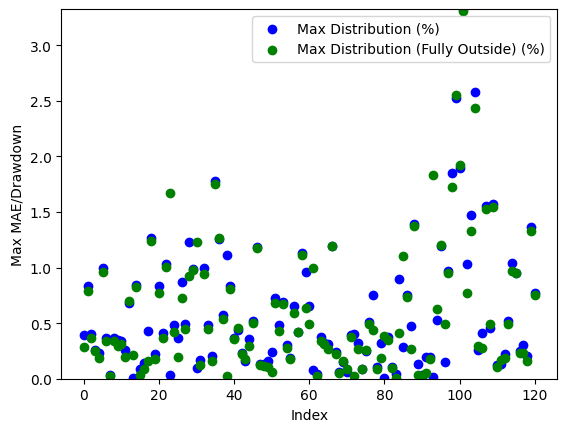

MES=F


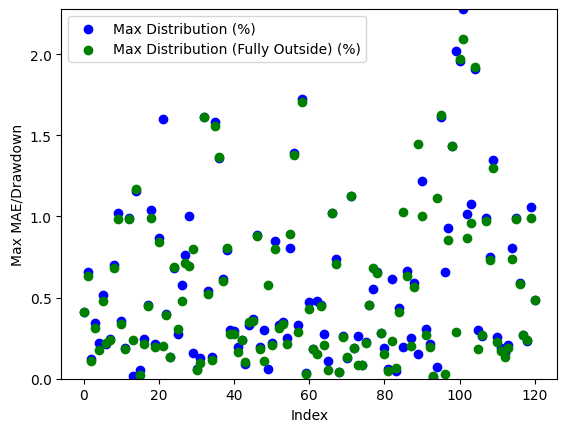

MYM=F


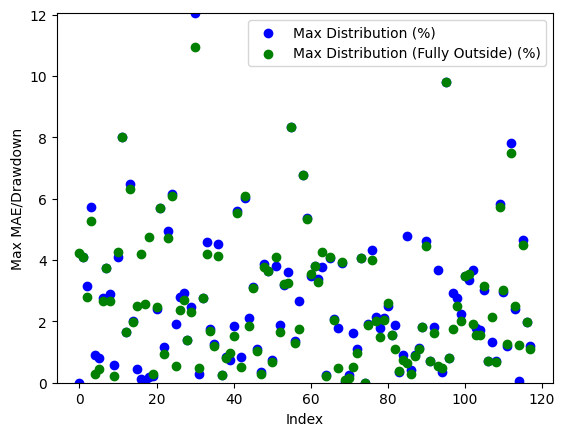

NG=F


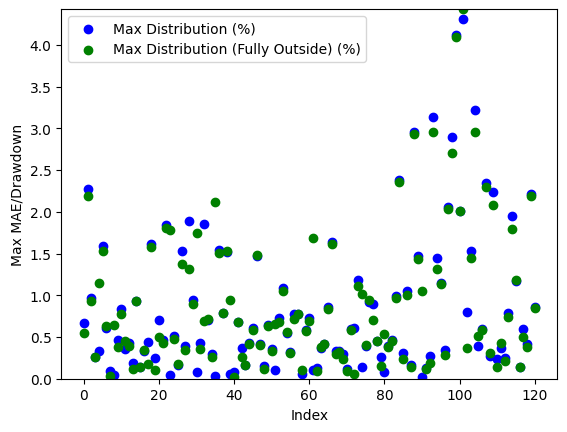

MNQ=F


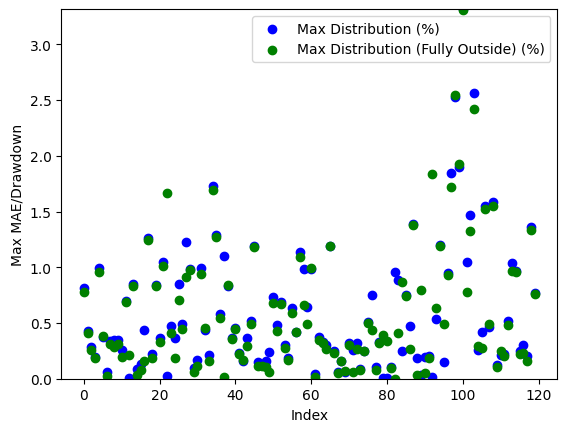

ES=F


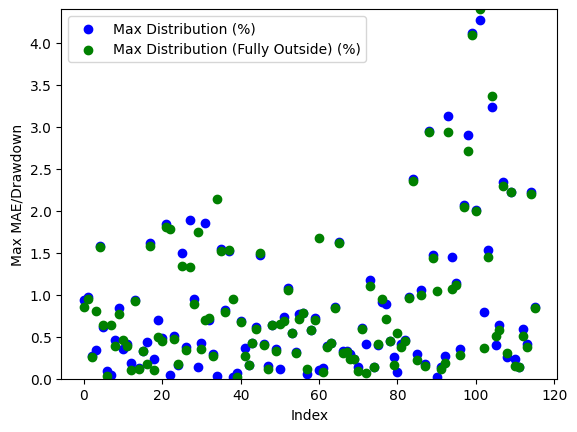

NQ=F


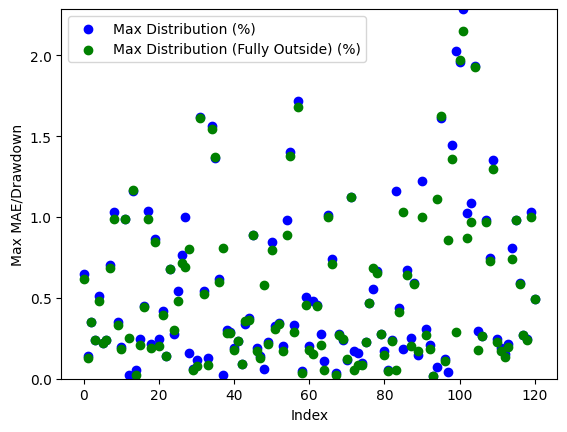

YM=F


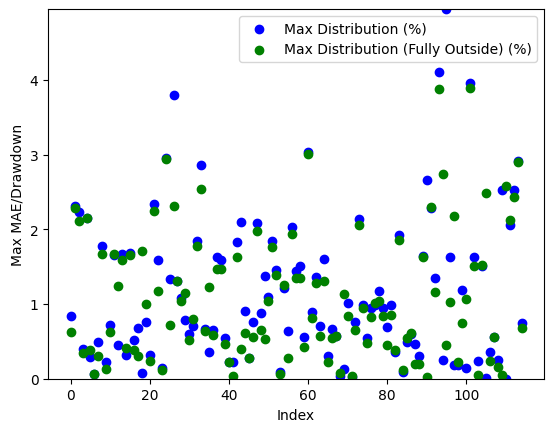

CL=F


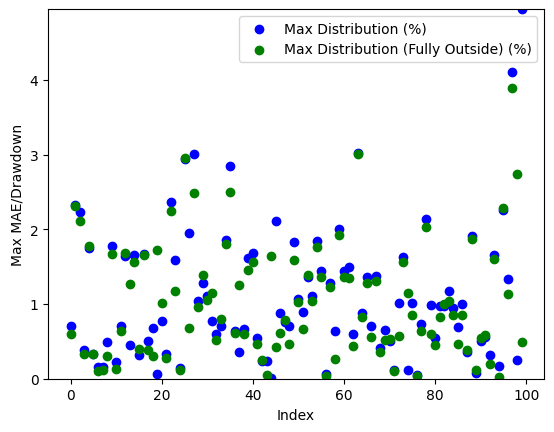

MCL=F


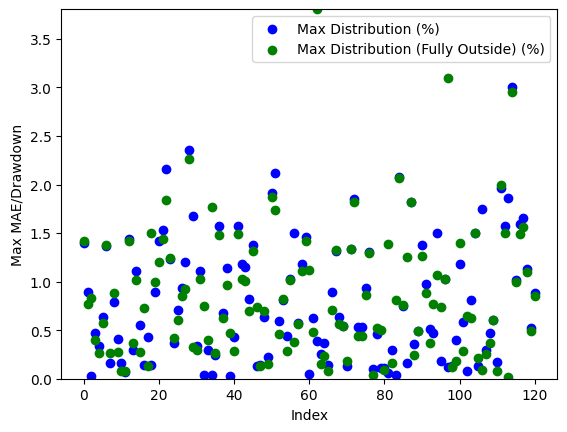

GC=F


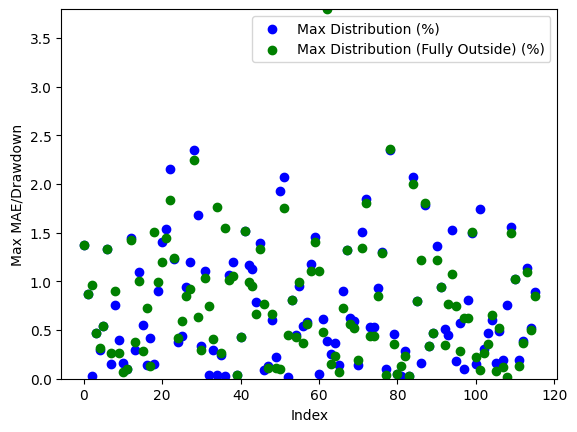

MGC=F


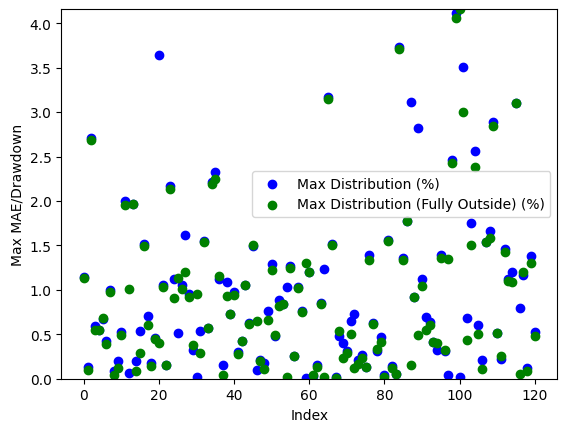

RTY=F


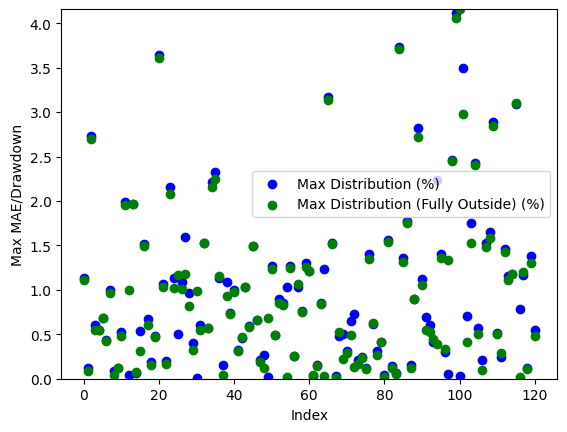

M2K=F


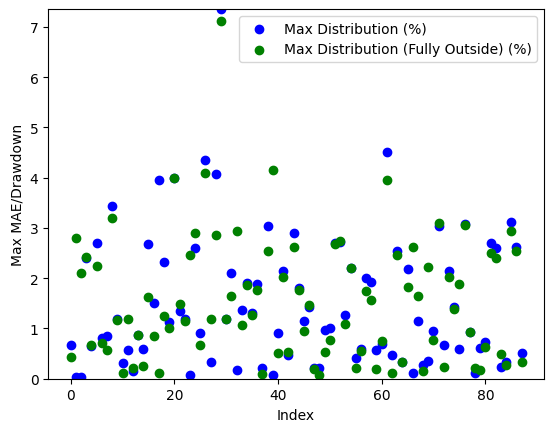

SI=F


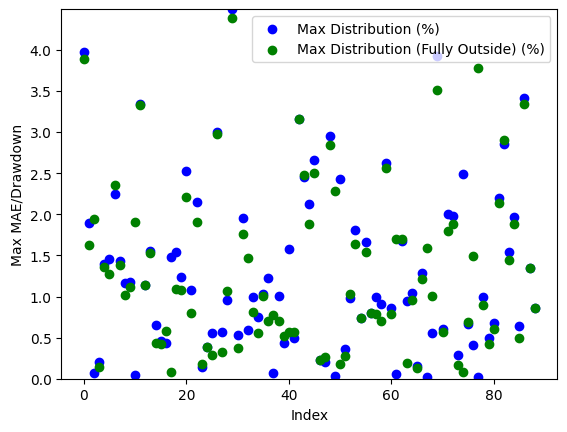

PL=F


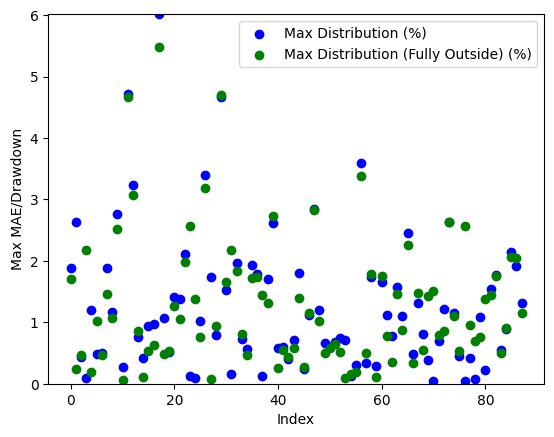

HG=F


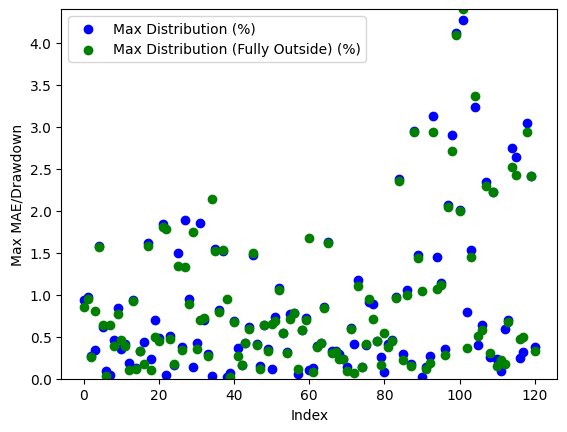

SIL=F
Done


<Figure size 640x480 with 0 Axes>

In [14]:
for ticker in TickerList:
    # df2 = pd.read_csv(f'Backtest Results/1 Minute Timeframe Results/{ticker.split('=')[0]}_1min.csv', index_col=False)
    # df2 = pd.read_csv(f'Backtest Results/5 Minute Timeframe Results/{ticker.split('=')[0]}_5min.csv', index_col=False)
    df2 = pd.read_csv(f'Backtest Results/15 Minute Timeframe Results/{ticker.split('=')[0]}_15min.csv', index_col=False)
    
    plt.scatter(df2.index, df2['Max Distribution (%)'], color='blue', label='Max Distribution (%)')
    plt.scatter(df2.index, df2['Max Distribution (Fully Outside) (%)'], color='green', label='Max Distribution (Fully Outside) (%)')
    
    # Set the y-axis range based on the maximum value from both columns
    y_max = max(df2['Max Distribution (%)'].max(), df2['Max Distribution (Fully Outside) (%)'].max())
    plt.ylim(0, y_max)
    
    # Add labels, title, and legend
    plt.xlabel('Index')
    plt.ylabel('Max MAE/Drawdown')
    # plt.title('Scatter Plot of Two Columns')
    plt.legend()
    # plt.show()
    
    # Save the plot
    # plt.savefig(f'Backtest Results/1 Minute Timeframe Results/{ticker.split('=')[0]}_1min.png')
    # plt.savefig(f'Backtest Results/5 Minute Timeframe Results/{ticker.split('=')[0]}_5min.png')
    plt.savefig(f'Backtest Results/15 Minute Timeframe Results/{ticker.split('=')[0]}_15min.png')
    
    
    plt.show()
    plt.clf()
    print(ticker)
    # break

print('Done')

In [ ]:
final_df.columns

In [ ]:
final_df.head(1)

In [ ]:
df4 = pd.DataFrame(index=['Asset', 'Wins:', 'Losses:', 'Strike Rate:'])

for ticker in TickerList:
    df3 = pd.read_csv(f'Backtest Results/1 Minute Timeframe Results/{ticker.split('=')[0]}_1min.csv', index_col=False)
    # df3 = pd.read_csv(f'Backtest Results/5 Minute Timeframe Results/{ticker.split('=')[0]}_5min.csv', index_col=False)
    # df3 = pd.read_csv(f'Backtest Results/15 Minute Timeframe Results/{ticker.split('=')[0]}_15min.csv', index_col=False)
    
    wins = 0
    loss = 0

    for result in df3['Win/(Loss)']:
        if result == 'Win':
            wins += 1
        else:
            loss += 1
    # Alternatively, using vectorized operations (more efficient)
    # wins = (final_df['Win/(Loss)'] == 'Win').sum()
    # loss = (final_df['Win/(Loss)'] != 'Win').sum()
    
    StrikeRate = round((wins / (wins + loss)) * 100, 3)
    wins = round(wins, 3)
    loss = round(loss, 3)
    
    just_ticker = ticker.split('=')[0]
    df4[just_ticker] = [just_ticker, wins, loss, StrikeRate]
    print(ticker)
    print('Wins: ', wins)
    print('Loss: ', loss)
    print('Strike Rate: ', StrikeRate)
    # break

print('Done')

In [49]:
# df4.to_csv('Asia Retracement Stats.csv')